# Merge Sort Lab 🧠🧰
In this notebook, we will:

1. Implement merge sort (recursive) and the merge step.
2. Count *comparisons* made during sorting.
3. Experimentally confirm the book’s big claim: merge sort uses about **O(n log n)** comparisons.

### What the book gives us
- A recursive picture of merge sort splitting and merging a list (see the diagram on page 3).
- **Algorithm 9**: recursive merge sort (page 4).
- **Algorithm 10**: merging two sorted lists (page 5).
- A key bound: merge sort comparisons are **O(n log n)** (page 6).

We'll turn those ideas into runnable code and evidence.


## Quick intuition
Merge sort does two repeated actions:

### 1) Split
Keep splitting the list into halves until each piece has size 1.

### 2) Merge
Merge sorted halves back together.
The merge step is where comparisons happen.

A key fact from the text:
If you merge two sorted lists with lengths `m` and `n`,
the merge needs at most **m + n − 1** comparisons.
(That’s the engine behind the O(n log n) result.)


In [2]:
from dataclasses import dataclass
import random
import math
import time

@dataclass
class SortStats:
    comparisons: int = 0
    writes: int = 0   # how many items we append into merged output


## Tracking “what happened” during sorting (Stats object)

This cell defines a tiny data container called `SortStats`. It’s not part of merge sort *itself*, it’s a **scoreboard** we carry along while the algorithm runs.

### What `@dataclass` does for us
`@dataclass` tells Python: “This is mostly just data.”
So Python automatically creates helpful boilerplate like:
- an `__init__` method (so we can do `SortStats()` easily),
- a nice printable representation (so we can see the values cleanly),
- and consistent field handling.

That means we can focus on the *algorithm*, not on writing boring setup code.

### What the fields mean
- `comparisons`: how many times we compared two items (like `left[i] <= right[j]`)
- `writes`: how many items we placed into the merged output list

These numbers give us a concrete way to test ideas from the book, like:
- “Merging two sorted lists of sizes m and n takes at most m + n − 1 comparisons.”
- “Merge sort has about O(n log n) comparisons overall.”

### Why the “bottom half” matters (the `= 0` defaults)
The lines:
```python
comparisons: int = 0
writes: int = 0
are default starting values.

Without them, Python would require you to provide values every time:

SortStats(comparisons=0, writes=0)  # annoying and easy to forget
With defaults, you can just do:

stats = SortStats()
That’s the whole point: we want a fresh, empty scoreboard every time we run the sort,
so our measurements start at zero and the results are trustworthy.

In [3]:
def merge_sorted_lists(left, right, stats: SortStats):
    """
    Merge two already-sorted lists into one sorted list.

    We count:
      - stats.comparisons: element-to-element comparisons (left[i] <= right[j])
      - stats.writes: how many values we write into the output list
    """
    merged = []
    i = 0
    j = 0

    # While both lists still have items left to compare...
    while i < len(left) and j < len(right):
        # This is the "real" comparison merge sort analysis cares about:
        stats.comparisons += 1

        if left[i] <= right[j]:
            merged.append(left[i])
            stats.writes += 1
            i += 1
        else:
            merged.append(right[j])
            stats.writes += 1
            j += 1

    # One of the lists ran out. Copy the leftovers from the other list.
    # No more element-to-element comparisons are needed here.
    if i < len(left):
        merged.extend(left[i:])
        stats.writes += (len(left) - i)

    if j < len(right):
        merged.extend(right[j:])
        stats.writes += (len(right) - j)

    return merged


## Why we only add 1 comparison inside the loop

The book’s claim about merging two lists (like “at most m + n − 1 comparisons”) is counting
**comparisons between the actual data values**, not bookkeeping checks.

In our code, the only place we compare *values* from the lists is here:

```python
if left[i] <= right[j]:
So that’s what stats.comparisons measures.
```

The while i < len(left) and j < len(right) line does evaluate two conditions,
but those are index/bounds checks, not comparisons of elements.
They matter for runtime in real machines, but they are not what the classic merge sort math is tracking.


```markdown
## Step-by-step: what the merge function does

We are given two lists:
- `left` is already sorted
- `right` is already sorted

Our goal: build `merged`, a new sorted list containing everything from both.

### 1) Start with empty output and two pointers
- `merged = []` will hold the final sorted result
- `i` points into `left`
- `j` points into `right`

### 2) Repeatedly pick the smaller “front” element
While both lists still have unprocessed items:
1. Compare the current front items: `left[i]` and `right[j]`
2. Whichever is smaller gets appended into `merged`
3. Move that list’s pointer forward (`i += 1` or `j += 1`)
4. Each append is a “write” into the output list
5. Each element-to-element decision uses exactly **one** comparison

### 3) Copy leftovers after one list runs out
Eventually, either:
- `i == len(left)` (we used all of `left`), or
- `j == len(right)` (we used all of `right`)

At that moment, the remaining items in the other list are already sorted,
and they are all larger than everything we already placed into `merged`.

So we can copy them straight in with `extend(...)`:
- no more element comparisons needed
- but we still count the writes because we are still adding items to `merged`

### 4) Return the merged sorted list
`merged` is sorted and contains all items from both inputs.
```


In [4]:
def merge_sort(arr, stats: SortStats):
    """
    Recursive merge sort.
    Splits list, sorts halves recursively, then merges.
    """
    if len(arr) <= 1:
        return arr

    mid = len(arr) // 2
    left_sorted = merge_sort(arr[:mid], stats)
    right_sorted = merge_sort(arr[mid:], stats)

    return merge_sorted_lists(left_sorted, right_sorted, stats)


In [5]:
data = [8, 2, 4, 6, 9, 7, 10, 1, 5, 3]  # similar to the page-3 example list
stats = SortStats()
sorted_data = merge_sort(data, stats)

sorted_data, stats


([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], SortStats(comparisons=22, writes=34))

## What should we expect?
If `n = 10`, merge sort splits into halves until size 1, then merges back.

The book’s storyline:
- merge step comparisons are bounded (≤ m + n − 1)
- total merges happen across about log2(n) "levels"
- so total comparisons scale like **n log2(n)**

Next: we’ll measure comparisons for different `n` and compare to `n log2(n)`.


In [6]:
def run_one_trial(n, seed=None):
    if seed is not None:
        random.seed(seed)
    arr = [random.randint(0, 10**9) for _ in range(n)]
    stats = SortStats()
    out = merge_sort(arr, stats)
    assert out == sorted(arr), "Sort failed!"
    return stats.comparisons

def run_experiment(ns, trials=30):
    results = {}
    for n in ns:
        comps = [run_one_trial(n) for _ in range(trials)]
        results[n] = {
            "avg_comparisons": sum(comps) / len(comps),
            "min_comparisons": min(comps),
            "max_comparisons": max(comps),
            "n_log2_n": n * math.log2(n) if n > 1 else 0
        }
    return results

ns = [8, 16, 32, 64, 128, 256, 512, 1024]
results = run_experiment(ns, trials=40)
results


{8: {'avg_comparisons': 15.375,
  'min_comparisons': 13,
  'max_comparisons': 17,
  'n_log2_n': 24.0},
 16: {'avg_comparisons': 46.15,
  'min_comparisons': 42,
  'max_comparisons': 49,
  'n_log2_n': 64.0},
 32: {'avg_comparisons': 122.1,
  'min_comparisons': 115,
  'max_comparisons': 128,
  'n_log2_n': 160.0},
 64: {'avg_comparisons': 305.45,
  'min_comparisons': 295,
  'max_comparisons': 312,
  'n_log2_n': 384.0},
 128: {'avg_comparisons': 737.725,
  'min_comparisons': 726,
  'max_comparisons': 747,
  'n_log2_n': 896.0},
 256: {'avg_comparisons': 1726.475,
  'min_comparisons': 1712,
  'max_comparisons': 1741,
  'n_log2_n': 2048.0},
 512: {'avg_comparisons': 3961.475,
  'min_comparisons': 3928,
  'max_comparisons': 3987,
  'n_log2_n': 4608.0},
 1024: {'avg_comparisons': 8947.775,
  'min_comparisons': 8904,
  'max_comparisons': 8983,
  'n_log2_n': 10240.0}}

## Reading the results
We computed:
- average comparisons actually used
- the value `n log2(n)` as a reference scale

We do **not** expect comparisons to equal `n log2(n)` exactly.
We *do* expect the comparisons to grow proportionally to it.


In [7]:
def print_table(results):
    print(f"{'n':>6} | {'avg comps':>12} | {'n log2 n':>12} | {'avg/(n log2 n)':>14}")
    print("-" * 55)
    for n in sorted(results.keys()):
        avg_c = results[n]["avg_comparisons"]
        ref = results[n]["n_log2_n"]
        ratio = (avg_c / ref) if ref else float('nan')
        print(f"{n:>6} | {avg_c:>12.2f} | {ref:>12.2f} | {ratio:>14.4f}")

print_table(results)


     n |    avg comps |     n log2 n | avg/(n log2 n)
-------------------------------------------------------
     8 |        15.38 |        24.00 |         0.6406
    16 |        46.15 |        64.00 |         0.7211
    32 |       122.10 |       160.00 |         0.7631
    64 |       305.45 |       384.00 |         0.7954
   128 |       737.73 |       896.00 |         0.8234
   256 |      1726.47 |      2048.00 |         0.8430
   512 |      3961.47 |      4608.00 |         0.8597
  1024 |      8947.77 |     10240.00 |         0.8738


### What does the ratio mean?
If merge sort is O(n log n), then:

avg_comparisons ≈ C * (n log2 n)

So the ratio avg_comparisons / (n log2 n) should hover around a constant C
as n grows (it might wiggle a bit, but it shouldn’t explode).

If the ratio grows without bound, we'd be in trouble.
If it stabilizes, that’s empirical evidence for O(n log n).


In [8]:
import random
import time
import math

def time_one(func, data, repeats=3):
    """
    Time `func(data)` using a small number of repeats and return the best time.
    We use best-of-N to reduce noise from background processes.
    """
    best = float("inf")
    for _ in range(repeats):
        start = time.perf_counter()
        func(data)
        end = time.perf_counter()
        best = min(best, end - start)
    return best

def our_mergesort_wrapper(data):
    # We copy the data so each algorithm gets the same input
    stats = SortStats()
    out = merge_sort(list(data), stats)
    return out

def builtin_sorted_wrapper(data):
    return sorted(data)

def benchmark_sorts(
    sizes,
    trials_per_size=8,
    repeats_per_trial=2,
    seed=12345
):
    """
    For each n in sizes:
      - generate trials_per_size random lists of length n
      - time merge_sort vs built-in sorted on the same lists
      - return aggregated results
    """
    random.seed(seed)

    results = []  # list of dict rows
    for n in sizes:
        our_times = []
        builtin_times = []

        for _ in range(trials_per_size):
            data = [random.randint(0, 10**9) for _ in range(n)]

            # Warm correctness check (optional but nice)
            out1 = our_mergesort_wrapper(data)
            out2 = builtin_sorted_wrapper(data)
            assert out1 == out2, "Mismatch! Our merge sort result differs from built-in sorted()."

            # Timing
            our_t = time_one(our_mergesort_wrapper, data, repeats=repeats_per_trial)
            bi_t  = time_one(builtin_sorted_wrapper, data, repeats=repeats_per_trial)

            our_times.append(our_t)
            builtin_times.append(bi_t)

        results.append({
            "n": n,
            "our_best_avg_s": sum(our_times) / len(our_times),
            "builtin_best_avg_s": sum(builtin_times) / len(builtin_times),
            "speedup_builtin_over_ours": (sum(our_times) / len(our_times)) / (sum(builtin_times) / len(builtin_times))
        })

        print(f"n={n:>6}  ours={results[-1]['our_best_avg_s']:.6f}s  "
              f"builtin={results[-1]['builtin_best_avg_s']:.6f}s  "
              f"speedup={results[-1]['speedup_builtin_over_ours']:.2f}x")

    return results

# Let out a little magic smoke: bigger sizes than before
sizes = [2_000, 4_000, 8_000, 16_000, 32_000, 64_000]

bench = benchmark_sorts(
    sizes=sizes,
    trials_per_size=10,       # more trials = smoother signal
    repeats_per_trial=2,      # best-of-2 each trial
    seed=2026
)

bench


n=  2000  ours=0.002582s  builtin=0.000116s  speedup=22.31x
n=  4000  ours=0.005554s  builtin=0.000265s  speedup=21.00x
n=  8000  ours=0.012028s  builtin=0.000597s  speedup=20.16x
n= 16000  ours=0.025733s  builtin=0.001300s  speedup=19.79x
n= 32000  ours=0.056117s  builtin=0.002884s  speedup=19.46x
n= 64000  ours=0.118844s  builtin=0.006223s  speedup=19.10x


[{'n': 2000,
  'our_best_avg_s': 0.0025824899785220623,
  'builtin_best_avg_s': 0.00011576982215046882,
  'speedup_builtin_over_ours': 22.307108454961067},
 {'n': 4000,
  'our_best_avg_s': 0.005554250115528703,
  'builtin_best_avg_s': 0.00026453002355992795,
  'speedup_builtin_over_ours': 20.996671911876255},
 {'n': 8000,
  'our_best_avg_s': 0.012027620105072856,
  'builtin_best_avg_s': 0.0005965201184153557,
  'speedup_builtin_over_ours': 20.162974782852253},
 {'n': 16000,
  'our_best_avg_s': 0.02573266006074846,
  'builtin_best_avg_s': 0.0013003398664295674,
  'speedup_builtin_over_ours': 19.789180294382877},
 {'n': 32000,
  'our_best_avg_s': 0.05611669011414051,
  'builtin_best_avg_s': 0.002883580047637224,
  'speedup_builtin_over_ours': 19.460770704153664},
 {'n': 64000,
  'our_best_avg_s': 0.1188444699626416,
  'builtin_best_avg_s': 0.006223280029371381,
  'speedup_builtin_over_ours': 19.09675756220891}]

## Benchmarking: our merge sort vs Python’s built-in sort

Now we’re doing a fair fight between two sorting approaches:

### 1) Our merge sort (educational version)
- Written in Python
- Uses recursion and creates new lists during splitting/merging
- Great for learning the algorithm and the math
- Not optimized for raw speed

### 2) Python’s built-in `sorted()` (industrial version)
- Uses **Timsort** (a highly engineered hybrid sort)
- Written in **C** under the hood (fast loops, low overhead)
- Takes advantage of real-world patterns in data
- This is what you actually want in production most of the time

### How we benchmark fairly
For each list size `n`:
1. We generate the same random list of length `n`
2. We sort it with both methods
3. We confirm the results match (correctness check)
4. We time each method multiple times and keep the best timing per trial
   (this reduces noise from the OS doing random background stuff)

### What we expect
Both methods are **O(n log n)** in big-O terms, but:
- `sorted()` should be dramatically faster because it’s optimized and implemented in C
- Our Python merge sort will get slower faster due to Python-level overhead and extra allocations

So: same asymptotic family, different “constant factors”… and those constants can be *giant*.


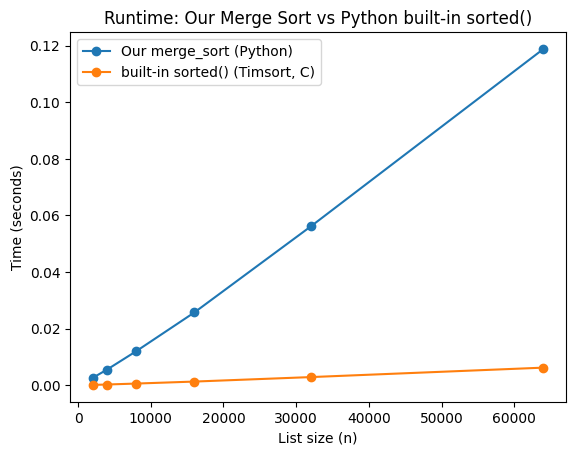

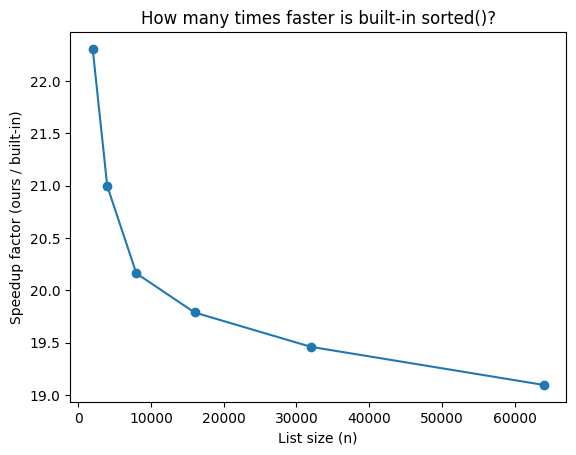

       n |     ours (s) | built-in (s) |   speedup
-----------------------------------------------------
    2000 |     0.002582 |     0.000116 |     22.31x
    4000 |     0.005554 |     0.000265 |     21.00x
    8000 |     0.012028 |     0.000597 |     20.16x
   16000 |     0.025733 |     0.001300 |     19.79x
   32000 |     0.056117 |     0.002884 |     19.46x
   64000 |     0.118844 |     0.006223 |     19.10x


In [9]:
import matplotlib.pyplot as plt

ns = [row["n"] for row in bench]
our = [row["our_best_avg_s"] for row in bench]
bi  = [row["builtin_best_avg_s"] for row in bench]
speedup = [row["speedup_builtin_over_ours"] for row in bench]

# 1) Runtime plot
plt.figure()
plt.plot(ns, our, marker="o", label="Our merge_sort (Python)")
plt.plot(ns, bi, marker="o", label="built-in sorted() (Timsort, C)")
plt.xlabel("List size (n)")
plt.ylabel("Time (seconds)")
plt.title("Runtime: Our Merge Sort vs Python built-in sorted()")
plt.legend()
plt.show()

# 2) Speedup plot (how many times faster built-in is)
plt.figure()
plt.plot(ns, speedup, marker="o")
plt.xlabel("List size (n)")
plt.ylabel("Speedup factor (ours / built-in)")
plt.title("How many times faster is built-in sorted()?")
plt.show()

# 3) Print a neat summary table
print(f"{'n':>8} | {'ours (s)':>12} | {'built-in (s)':>12} | {'speedup':>9}")
print("-" * 53)
for row in bench:
    print(f"{row['n']:>8} | {row['our_best_avg_s']:>12.6f} | {row['builtin_best_avg_s']:>12.6f} | {row['speedup_builtin_over_ours']:>9.2f}x")
